# Mini-Probject Batch 2, Problem 2: An Oracle for Shor's 

Amanda Curtis and Arthur Diep-Nguyen, for the Erdos Institute's Quantum Computing Bootcamp, Summer 2025. 

This work is based off of sources cited at the end of the notebook. 

In the following notebook, we build an oracle for Shor's Algorithm in the case where N = 15. If time permits, we may generalize for more values of N. 

## Outline 

1. Explaination of Process, Rationale 
2. Building phiADD(a)
3. Building phiADD(a)mod(N)
4. Building CMult(a)mod(N)
5. The Complete Oracle 
6. Benchmarking and Analysis 
7. Sources 


## 1. Process and Rationale 

In [132]:
# Header from our .py document 

# filename: shors_alg.py
# authors: Amanda Curtis and Arthur Diep-Nguyen

# Checking that we have everything we need for qiskit 
%pip install qiskit pylatexenc

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
#import matplotlib.pyplot as plt

import numpy as np
import math

Note: you may need to restart the kernel to use updated packages.


## 2. Building phiADD(a)

In [210]:

def adder(a: int, N: int) -> QuantumCircuit:
    #TODO see Section 2.1 and Figure 3
    # Must first "solve" for n, set up registers needed
    # Based off of cited paper and QC Bootcamp 2's implementation of 
    # Draper's adder circuit 
    # and class lecture on 22 May 2025

    # We utilize the corollary that relates the QFT, A_k (Draper), 
    # and this (controlled) phase gate P_n(a) (phiADD(a)) 

    # "Solving" for n, necessary to determine number of qubits 
    n = int(np.ceil(np.log2(N)))

    # Setting up Quantum Register 
    quantum_register = QuantumRegister(size=n, name ='x')
    phi_add_a = QuantumCircuit(quantum_register, name="phi_add_a")

    # Building P_n(a) by making a phase gate p
    # for each qubit 
    for idx, q in enumerate(reversed(quantum_register)):
        phi_add_a.p(np.pi * a / (1 << idx), q)

    

    return phi_add_a
    

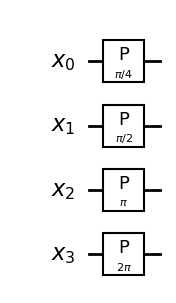

In [211]:
# Testing adder
adder(2, 15).draw(output="mpl", style="bw")

We must also create the inverse adder. We call it subtractor. Again, we consult Problem Session 2's notebook for inspiration.  

In [135]:
def subtractor(a: int, N: int) -> QuantumCircuit:
    #TODO see Section 2.2, used in figure 5's construction

    # "Solving" for n, necessary to determine number of qubits 
    n = int(np.ceil(np.log2(N)))

    # Setting up Quantum Register 
    quantum_register = QuantumRegister(size=n, name ='x')
    phi_sub_a = QuantumCircuit(quantum_register, name="phi_sub_a")

    # Building rev(P_n(a)) by making a phase gate p
    # for each qubit 
    for idx, q in enumerate(reversed(quantum_register)):
        phi_sub_a.p(np.pi * -a / (1 << idx), q)

    

    return phi_sub_a

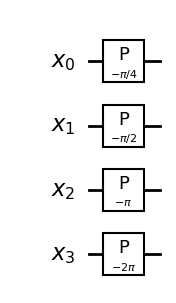

In [136]:
# testing subtractor 
subtractor(2, 15).draw(output="mpl", style="bw")

## 3. Building phiADD(a)mod(N)

Before building the full cc_adder_mod circuit, we must build the controlled and doubly-controlled versions of the adder and subtractor functions defined above. 

### Here we create the controlled adder and subtractorgates

We note that the modular adder gate only requires the adder, with the control ancilla being the extra ancilla. To ensure reversibility of phiADD(a)mod(N) in the multicontrolled multiplier gate, we will go ahead and make c_subtractor here as well. 

In [ ]:
# c adder gate
def c_adder(a: int, N: int) -> QuantumCircuit:
    #TODO see Section 2.1 and Figure 3
    # Must first "solve" for n, set up registers needed

    # "Solving" for n, necessary to determine number of qubits 
    n = math.ceil(math.log2(N))

    # Setting up Quantum Registers
    control_register = QuantumRegister(size=2, name='c')
    # This is the register where most of the work happens
    phi_b_register = QuantumRegister(size=n, name='phi(b)')

    # This register is for the extra qubit required
    # Naming to avoid confusion with the function input, a
    zero_register = AncillaRegister(size=1, name="zero")

    # Setting up the circuit 
    c_phi_add_a = QuantumCircuit(control_register, phi_b_register, zero_register, name='cc_phi_add_a')

    # Building cc_P_n(a) by making a phase gate p
    # for each qubit 
    for idx, q in enumerate(reversed(phi_b_register)):
        c_phi_add_a.cp(np.pi * a / (1 << idx), zero_register[0], q)

    return c_phi_add_a

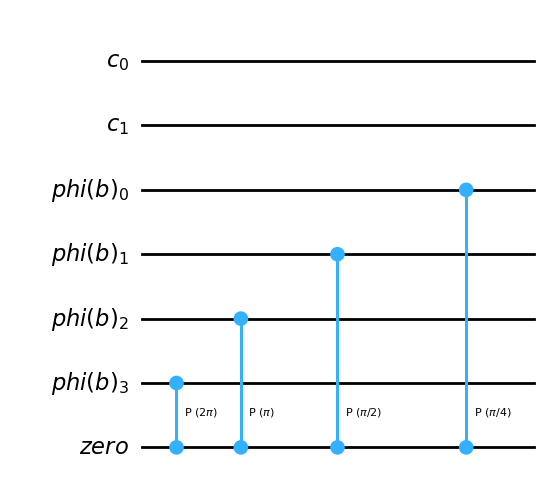

In [181]:
c_adder(2,15).draw('mpl')

In [188]:
# c subtractor gate
def c_subtractor(a: int, N: int) -> QuantumCircuit:
    #TODO see Section 2.1 and Figure 3
    # Must first "solve" for n, set up registers needed

    # "Solving" for n, necessary to determine number of qubits 
    n = math.ceil(math.log2(N))

    # Setting up Quantum Registers
    control_register = QuantumRegister(size=2, name='c')
    # This is the register where most of the work happens
    phi_b_register = QuantumRegister(size=n, name='phi(b)')

    # This register is for the extra qubit required
    # Naming to avoid confusion with the function input, a
    zero_register = AncillaRegister(size=1, name="zero")

    # Setting up the circuit 
    c_phi_sub_a = QuantumCircuit(control_register, phi_b_register, zero_register, name='cc_phi_add_a')

    # Building cc_P_n(a) by making a phase gate p
    # for each qubit 
    for idx, q in enumerate((phi_b_register)):
        c_phi_sub_a.cp(np.pi * -a / (2**(n-1-idx)), zero_register[0], q)

    return c_phi_sub_a

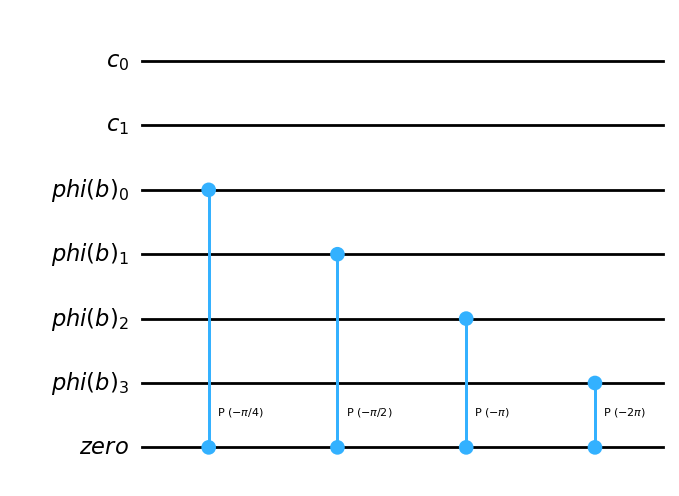

In [189]:
c_subtractor(2,15).draw('mpl')

#### Here we create the doubly-controlled adder and subtractor gates 

In [159]:
# cc adder gate
def cc_adder(a: int, N: int) -> QuantumCircuit:
    #TODO see Section 2.1 and Figure 3
    # Must first "solve" for n, set up registers needed

    # "Solving" for n, necessary to determine number of qubits 
    n = math.ceil(math.log2(N))

    # Setting up Quantum Registers
    control_register = QuantumRegister(size=2, name='c')
    # This is the register where most of the work happens
    phi_b_register = QuantumRegister(size=n, name='phi(b)')

    # This register is for the extra qubit required
    # Naming to avoid confusion with the function input, a
    zero_register = AncillaRegister(size=1, name="zero")

    # Setting up the circuit 
    cc_phi_add_a = QuantumCircuit(control_register, phi_b_register, zero_register, name='cc_phi_add_a')

    # Building cc_P_n(a) by making a phase gate p
    # for each qubit 
    for idx, q in enumerate(reversed(phi_b_register)):
        cc_phi_add_a.mcp(np.pi * a / (1 << idx), control_register[:], q)

    return cc_phi_add_a

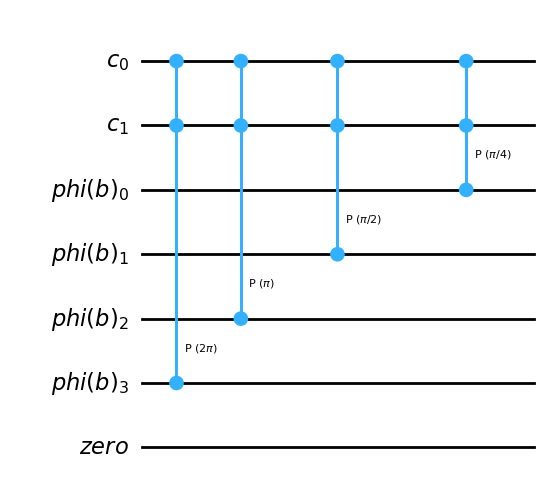

In [160]:
# testing with a = 2, N = 15
cc_adder(2,15).draw('mpl')

In [161]:
# cc subtractor gate 
def cc_subtractor(a: int, N: int) -> QuantumCircuit:
    #TODO see Section 2.1 and Figure 3
    # Must first "solve" for n, set up registers needed

    # "Solving" for n, necessary to determine number of qubits 
    n = math.ceil(math.log2(N))

    # Setting up Quantum Registers
    control_register = QuantumRegister(size=2, name='c')
    # This is the register where most of the work happens
    phi_b_register = QuantumRegister(size=n, name='phi(b)')

    # This register is for the extra qubit required
    # Naming to avoid confusion with the function input, a
    zero_register = AncillaRegister(size=1, name="zero")

    # Setting up the circuit 
    cc_phi_sub_a = QuantumCircuit(control_register, phi_b_register, zero_register, name='cc_phi_add_a')

    # Building cc_P_n(a) by making a phase gate p
    # for each qubit 
    for idx, q in enumerate((phi_b_register)):
        cc_phi_sub_a.mcp(np.pi * -a / (2**(n-1-idx)), control_register[:], q)

    return cc_phi_sub_a

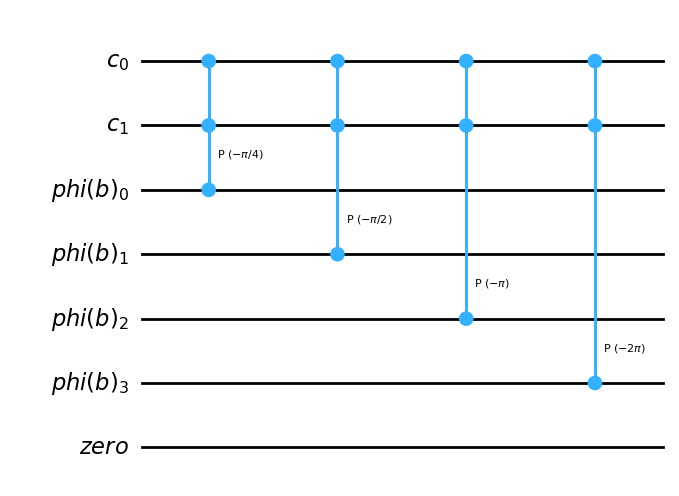

In [162]:
# testing 
cc_subtractor(2,15).draw('mpl')

In [206]:
# Copying outline of code from our .py file 

def adder_mod(a: int, N: int) -> QuantumCircuit:
    #TODO doubly controlled, see Section 2.2 and Figure 5
   
   # "Solving" for n, necessary to determine number of qubits 
    n = math.ceil(math.log2(N))

    # Makking the control register, which requires two qubits
    control_register = QuantumRegister(size=2, name='c')
    # This is the register where most of the work happens
    phi_b_register = QuantumRegister(size=n, name='phi(b)')
    # This register is for the extra qubit required
    # Naming to avoid confusion with the function input, a
    zero_register = AncillaRegister(size=1, name="zero")

    # Creating the actual circuit 
    # naming it 'adder_mod_N'
    adder_mod_N = QuantumCircuit(control_register, phi_b_register, zero_register, name='cc_adder_mod_N')

    # gate 1/13 - cc_adder with a
    # ensuring cleaner code by naming gate and specifying a, N
    cc_adder_aN = cc_adder(a,N)
    adder_mod_N.compose(cc_adder_aN, qubits=[*control_register[:], *phi_b_register[:], *zero_register[:]], inplace=True)

    adder_mod_N.barrier()

    # gate 2/13 inverse adder (aka subtractor) with a = N
    sub_N = subtractor(N,N)
    adder_mod_N.compose(sub_N, qubits=[*phi_b_register[:]], inplace=True)

    adder_mod_N.barrier()

    # gate 3/13 qft_inv
    adder_mod_N.compose(QFT(n).inverse(), phi_b_register[:], inplace=True)

    adder_mod_N.barrier()

    # gate 4/13 controlled NOT (.cx)
    adder_mod_N.cx(phi_b_register[n-1], zero_register[0])

    adder_mod_N.barrier()

    # gate 5/13 qft
    adder_mod_N.compose(QFT(n), phi_b_register[:], inplace=True)

    adder_mod_N.barrier()

    # gate 6/13 controlled adder with a = N 
    c_add_N = c_adder(N,N)
    adder_mod_N.compose(c_add_N, qubits=[*control_register[:], *phi_b_register[:], *zero_register[:]], inplace=True)

    adder_mod_N.barrier()

    # gate 7/13 doubly controlled adder inverse (aka doubly controlled subtractor) for a
    cc_sub_a = cc_subtractor(a,N)
    adder_mod_N.compose(cc_sub_a, qubits=[*control_register[:], *phi_b_register[:], *zero_register[:]], inplace=True)

    adder_mod_N.barrier()

    # gate 8/13 qft inverse on phi_b
    adder_mod_N.compose(QFT(n).inverse(), phi_b_register[:], inplace=True)

    adder_mod_N.barrier()

    # gate 9/13 NOT (aka x)
    adder_mod_N.x(phi_b_register[n-1])

    adder_mod_N.barrier()

    # gate 10/13 controlled NOT (cx)
    adder_mod_N.cx(phi_b_register[n-1], zero_register[0])

    adder_mod_N.barrier()

    # gate 11/13 NOT (aka X)
    adder_mod_N.x(phi_b_register[n-1])

    adder_mod_N.barrier()

    # gate 12/13 qft 
    adder_mod_N.compose(QFT(n), phi_b_register[:], inplace=True)

    adder_mod_N.barrier()

    # gate 13/13 doubly controlled adder 
    cc_sub_a = cc_subtractor(a,N)
    adder_mod_N.compose(cc_sub_a, qubits=[*control_register[:], *phi_b_register[:], *zero_register[:]], inplace=True)



     

    return adder_mod_N
    

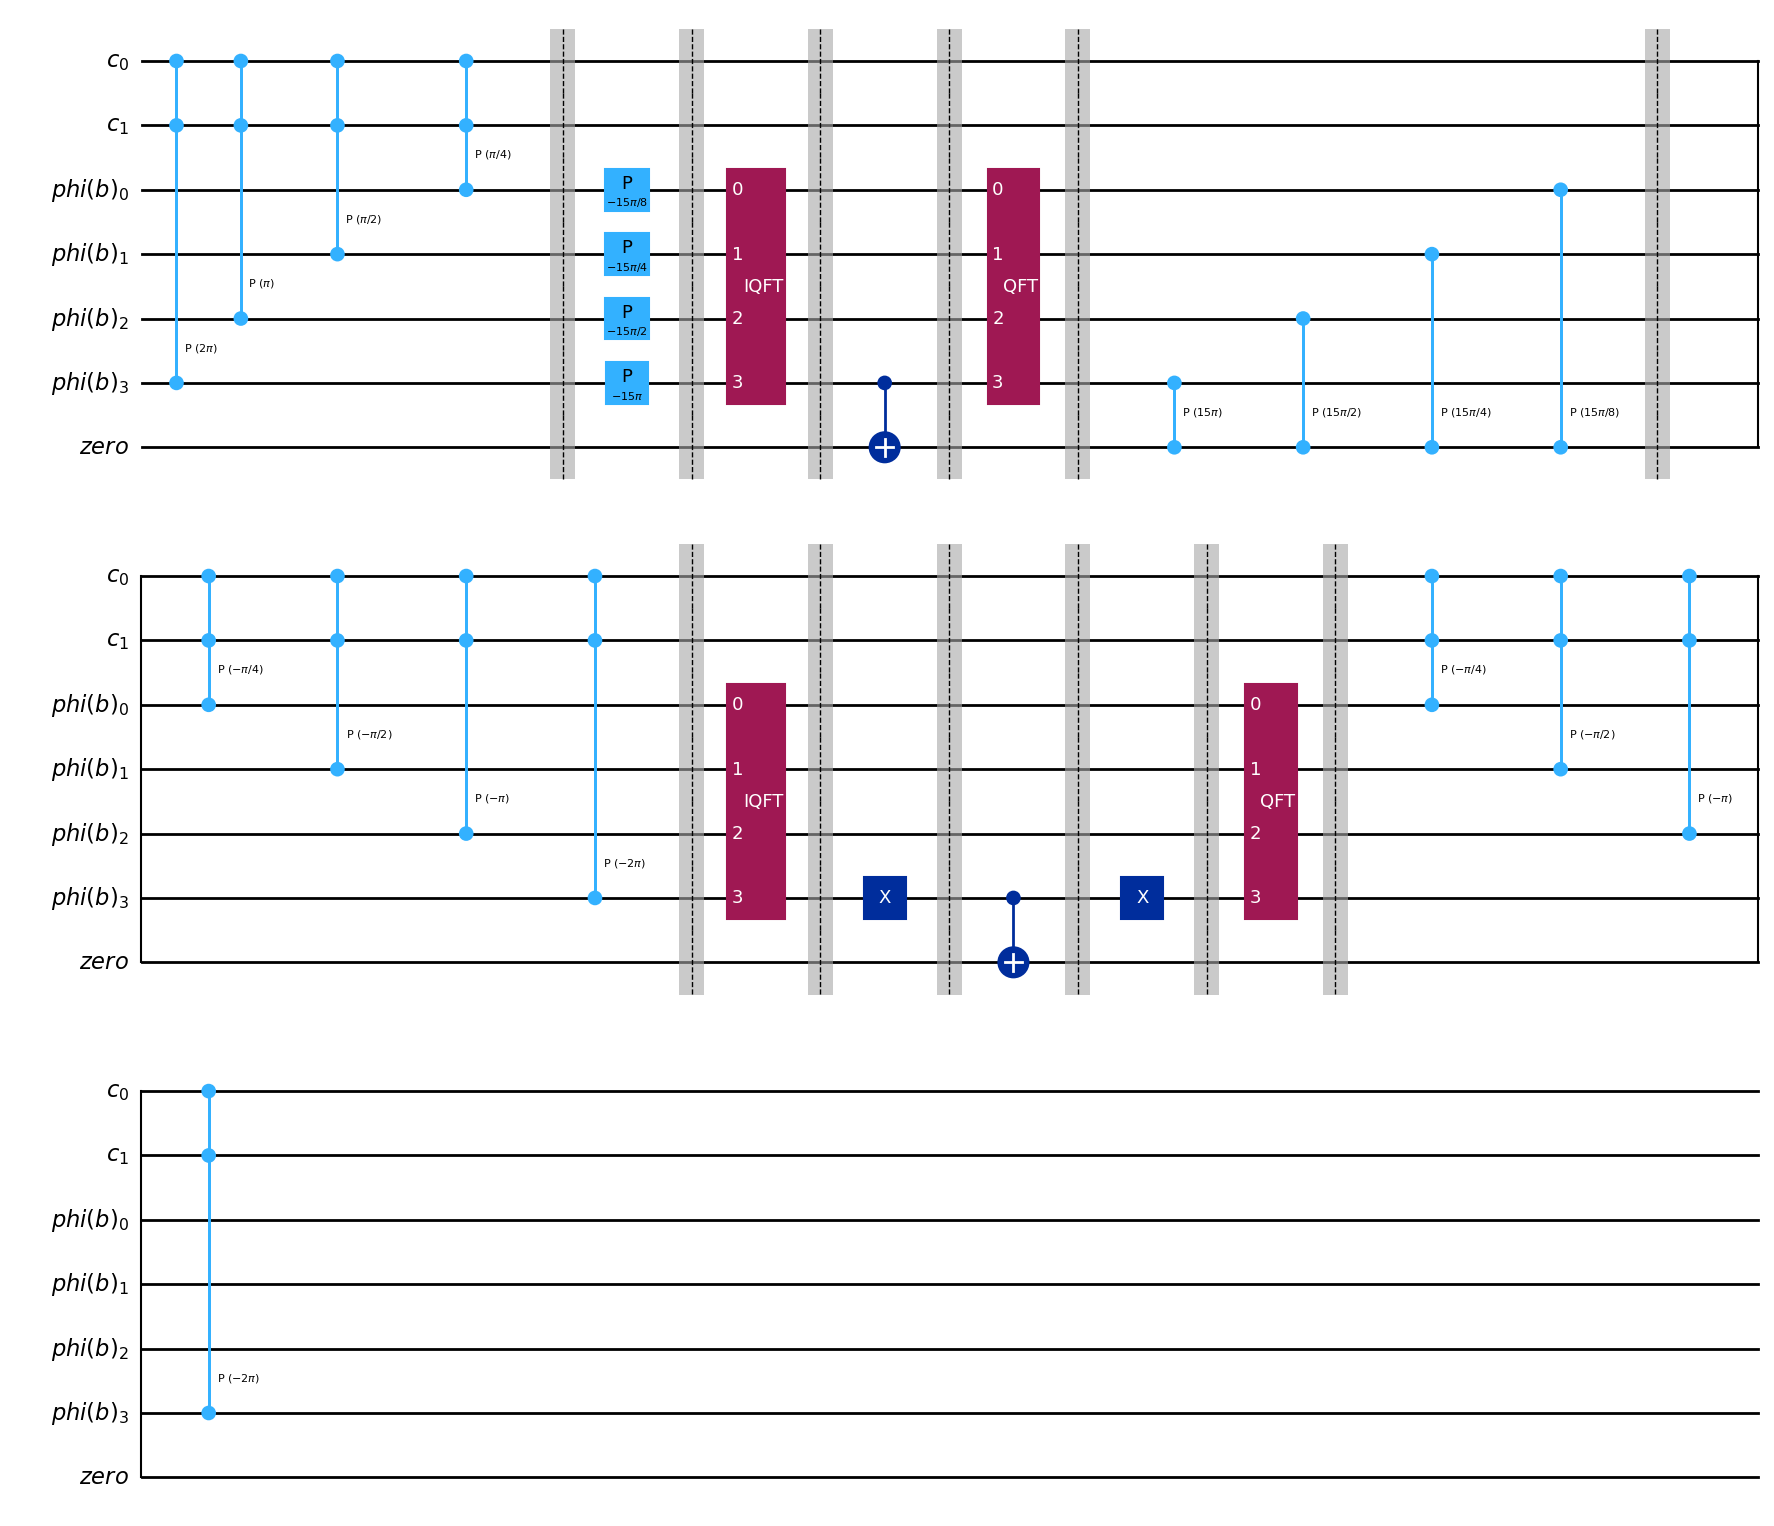

In [207]:
# testing cc_adder_mod
adder_mod(2,15).draw('mpl')

## 4. Building CMult(a)mod(N)

## 5. The Complete Oracle 

## 6. Benchmarking and Analysis 

## 7. Sources 